In [1]:
import numpy as np
from fractions import Fraction
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

## Linear Case
$$
\tau(n) = \frac{1}{n(n-1)}\sum_{u+v=n}au\tau(u)\tau(v).
$$

In [181]:
def deg_1_array(a_min,a_max,seq_length):
    a_len = a_max+1 - a_min
    
    a_range = np.arange(a_min, a_max+1)
    u_range = np.arange(seq_length)
    
    au_array = np.multiply.outer(a_range,u_range)
    
    return au_array

def deg_1_sqnc(a_min,a_max,seq_length,c=1,d=-1):
    a_len = a_max+1 - a_min
    
    coeff_array = deg_1_array(a_min,a_max,seq_length)
    seq = np.zeros(seq_length)
    seq[1] = 1
    seq_array = np.broadcast_to(seq, (a_len,seq_length)).copy()
    
    for n in range(2,seq_length):
        vec_A = coeff_array[:,1:n]*seq_array[:,1:n]
        vec_B = seq_array[:,n-1:0:-1]
        seq_array[:,n] = (1/(n*(c*n+d)))*np.sum(vec_A*vec_B, axis=1)
    
    return seq_array

def deg_1_case(a,seq_length,c=1,d=-1):
    seq = [0]*seq_length
    seq[1] = Fraction(1,1)
    for n in range(2,seq_length):
        seq_sum = 0
        for u in range(1,n):
            v = n-u
            seq_sum += (a*u)*seq[u]*seq[v]
        if c*n + d == 0:
            seq[n] = seq_sum
        else:
            seq[n] = Fraction(1,n*(c*n+d))*seq_sum
    return seq

In [212]:
deg_1_case(8,100,2,-4)

[0,
 Fraction(1, 1),
 Fraction(8, 1),
 Fraction(32, 1),
 Fraction(128, 1),
 Fraction(512, 1),
 Fraction(2048, 1),
 Fraction(8192, 1),
 Fraction(32768, 1),
 Fraction(131072, 1),
 Fraction(524288, 1),
 Fraction(2097152, 1),
 Fraction(8388608, 1),
 Fraction(33554432, 1),
 Fraction(134217728, 1),
 Fraction(536870912, 1),
 Fraction(2147483648, 1),
 Fraction(8589934592, 1),
 Fraction(34359738368, 1),
 Fraction(137438953472, 1),
 Fraction(549755813888, 1),
 Fraction(2199023255552, 1),
 Fraction(8796093022208, 1),
 Fraction(35184372088832, 1),
 Fraction(140737488355328, 1),
 Fraction(562949953421312, 1),
 Fraction(2251799813685248, 1),
 Fraction(9007199254740992, 1),
 Fraction(36028797018963968, 1),
 Fraction(144115188075855872, 1),
 Fraction(576460752303423488, 1),
 Fraction(2305843009213693952, 1),
 Fraction(9223372036854775808, 1),
 Fraction(36893488147419103232, 1),
 Fraction(147573952589676412928, 1),
 Fraction(590295810358705651712, 1),
 Fraction(2361183241434822606848, 1),
 Fraction(944

In [216]:
sequence_thing = [1]
for n in range(1,21):
    entry = 8*4**(n-1)
    sequence_thing.append(entry)
sequence_thing

[1,
 8,
 32,
 128,
 512,
 2048,
 8192,
 32768,
 131072,
 524288,
 2097152,
 8388608,
 33554432,
 134217728,
 536870912,
 2147483648,
 8589934592,
 34359738368,
 137438953472,
 549755813888,
 2199023255552]

This is $\{8\cdot4^{n-1}\}_{n\in\mathbb{N}}$.

In [213]:
deg_1_case(6,21,2,-4)

[0,
 Fraction(1, 1),
 Fraction(6, 1),
 Fraction(18, 1),
 Fraction(54, 1),
 Fraction(162, 1),
 Fraction(486, 1),
 Fraction(1458, 1),
 Fraction(4374, 1),
 Fraction(13122, 1),
 Fraction(39366, 1),
 Fraction(118098, 1),
 Fraction(354294, 1),
 Fraction(1062882, 1),
 Fraction(3188646, 1),
 Fraction(9565938, 1),
 Fraction(28697814, 1),
 Fraction(86093442, 1),
 Fraction(258280326, 1),
 Fraction(774840978, 1),
 Fraction(2324522934, 1)]

In [214]:
sequence_thing = [1]
for n in range(1,21):
    entry = 6*3**(n-1)
    sequence_thing.append(entry)
sequence_thing

[1,
 6,
 18,
 54,
 162,
 486,
 1458,
 4374,
 13122,
 39366,
 118098,
 354294,
 1062882,
 3188646,
 9565938,
 28697814,
 86093442,
 258280326,
 774840978,
 2324522934,
 6973568802]

This is $\{6\cdot3^{n-1}\}_{n\in\mathbb{N}}$.

For $n$ such that $cn+d=0$, if we let $\tau(n) = \sum_{u+v=n}au\tau(u)\tau(v)$, then we sometimes get some kind of sequence $\{a\cdot r^{n-1}\}$, $r$ some rational.

## Quadratic Case
$$
\tau(n) = \frac{1}{n^2(n-1)}\sum_{u+v=n}(au^2+buv)\tau(u)\tau(v)
$$
$\sigma(n)$ is at $(-24,36)$.

In [218]:
def deg_2_array(a_min,a_max,b_min,b_max,seq_length):
    a_len = a_max+1 - a_min
    b_len = b_max+1 - b_min
    
    a_range = np.arange(a_min, a_max+1)
    b_range = np.arange(b_min, b_max+1)
    u_range = np.arange(seq_length)
    v_range = u_range
    
    au_squared_matrix = np.multiply.outer(a_range, u_range*u_range) # a x u
    au_tensor = np.broadcast_to(au_squared_matrix,(seq_length,b_len,a_len,seq_length)) # k x b x a x k
    #k,b,a,k --> a,b,k,k
    
    bu_matrix = np.multiply.outer(b_range,u_range) # b_len x seq_length
    buv_matrix = np.multiply.outer(bu_matrix,v_range) # b_len x seq_len x seq_len
    buv_tensor = np.broadcast_to(buv_matrix,(a_len,b_len,seq_length,seq_length))
    
    corrected_au_tensor = np.swapaxes(au_tensor, 0,2)
    #corrected_buv_tensor = np.swapaxes(buv_tensor, 2,3)
    
    tensor = corrected_au_tensor + buv_tensor
    
    P_array = np.swapaxes(tensor, 2,3)
    
    return P_array


def deg_2_sqnc(a_min,a_max,b_min,b_max,seq_length,c=1,d=-1):
    a_len = a_max+1 - a_min
    b_len = b_max+1 - b_min
    
    coeff_array = deg_2_array(a_min,a_max,b_min,b_max,seq_length)
    seq = np.zeros(seq_length)
    seq[1] = 1
    seq_array = np.broadcast_to(seq, (a_len,b_len,seq_length)).copy()
    
    flipped_array = coeff_array[:,:,::-1,:]
    for n in range(2,seq_length):
        diag = np.diagonal(flipped_array, -seq_length+n+1, axis1 = 2, axis2 = 3)[:,:,1:n]
        vec_A = diag*seq_array[:,:,1:n]
        vec_B = seq_array[:,:,n-1:0:-1]
        seq_array[:,:,n] = (1/((n**2)*(c*n+d)))*np.sum(vec_A*vec_B,axis=2)
    
    return seq_array


def deg_2_case(a,b,seq_length,c=1,d=-1):
    seq = [0]*seq_length
    seq[1] = Fraction(1,1)
    for n in range(2,seq_length):
        seq_sum = 0
        for u in range(1,n):
            v = n-u
            seq_sum += (a*u*u+b*u*v)*seq[u]*seq[v]
        if c*n+d == 0:
            seq[n] = seq_sum
        else:
            seq[n] = Fraction(1,n*n*(c*n+d))*seq_sum
    return seq

In [313]:
deg_2_case(4,4,21,0,1)

[0,
 Fraction(1, 1),
 Fraction(2, 1),
 Fraction(8, 1),
 Fraction(40, 1),
 Fraction(224, 1),
 Fraction(1344, 1),
 Fraction(8448, 1),
 Fraction(54912, 1),
 Fraction(366080, 1),
 Fraction(2489344, 1),
 Fraction(17199104, 1),
 Fraction(120393728, 1),
 Fraction(852017152, 1),
 Fraction(6085836800, 1),
 Fraction(43818024960, 1),
 Fraction(317680680960, 1),
 Fraction(2317200261120, 1),
 Fraction(16992801914880, 1),
 Fraction(125210119372800, 1),
 Fraction(926554883358720, 1)]

If $C_n$ is the catalan numbers, then this is $2^n\times C_n$ element-wise.

In [260]:
deg_2_case(2,2,21,0,1) # the catalan numbers!

[0,
 Fraction(1, 1),
 Fraction(1, 1),
 Fraction(2, 1),
 Fraction(5, 1),
 Fraction(14, 1),
 Fraction(42, 1),
 Fraction(132, 1),
 Fraction(429, 1),
 Fraction(1430, 1),
 Fraction(4862, 1),
 Fraction(16796, 1),
 Fraction(58786, 1),
 Fraction(208012, 1),
 Fraction(742900, 1),
 Fraction(2674440, 1),
 Fraction(9694845, 1),
 Fraction(35357670, 1),
 Fraction(129644790, 1),
 Fraction(477638700, 1),
 Fraction(1767263190, 1)]

In [325]:
deg_2_case(6,6,21,0,1)

[0,
 Fraction(1, 1),
 Fraction(3, 1),
 Fraction(18, 1),
 Fraction(135, 1),
 Fraction(1134, 1),
 Fraction(10206, 1),
 Fraction(96228, 1),
 Fraction(938223, 1),
 Fraction(9382230, 1),
 Fraction(95698746, 1),
 Fraction(991787004, 1),
 Fraction(10413763542, 1),
 Fraction(110546105292, 1),
 Fraction(1184422556700, 1),
 Fraction(12791763612360, 1),
 Fraction(139110429284415, 1),
 Fraction(1522031755700070, 1),
 Fraction(16742349312700770, 1),
 Fraction(185047018719324300, 1),
 Fraction(2054021907784499730, 1)]

This is $3^{n-1}\times C_n$.

Not a Touchard recurrence, but $\tau(n) = \frac{1}{n^2}\sum_{u+v=n}(au^2+auv)\tau(u)\tau(v)$ produces $(\frac{a}{2})^{n-1}\times C_n$.

## Cubic Case
$$
\tau(n) = \frac{1}{n^3(n-1)}\sum_{u+v=n}(au^3+bu^2v)\tau(u)\tau(v)
$$
$\sigma(n)$ is at $(-24,48)$.

In [6]:
def deg_3_array(a_min,a_max,b_min,b_max,seq_length):
    a_len = a_max+1 - a_min
    b_len = b_max+1 - b_min
    
    a_range = np.arange(a_min, a_max+1)
    b_range = np.arange(b_min, b_max+1)
    u_range = np.arange(seq_length)
    v_range = u_range
    
    au_squared_matrix = np.multiply.outer(a_range, u_range*u_range*u_range) # a x u^3
    au_tensor = np.broadcast_to(au_squared_matrix,(seq_length,b_len,a_len,seq_length)) # k x b x a x k
    #k,b,a,k --> a,b,k,k
    
    bu_matrix = np.multiply.outer(b_range,u_range*u_range) # b x u^2
    buv_matrix = np.multiply.outer(bu_matrix,v_range) # b x u^2 x v
    buv_tensor = np.broadcast_to(buv_matrix,(a_len,b_len,seq_length,seq_length)) # a x b x k x k
    
    corrected_au_tensor = np.swapaxes(au_tensor, 0,2)
    #corrected_buv_tensor = np.swapaxes(buv_tensor, 2,3)
    
    tensor = corrected_au_tensor + buv_tensor
    
    P_array = np.swapaxes(tensor, 2,3)
    
    return P_array


def deg_3_sqnc(a_min,a_max,b_min,b_max,seq_length,c=1,d=-1):
    a_len = a_max+1 - a_min
    b_len = b_max+1 - b_min
    
    coeff_array = deg_3_array(a_min,a_max,b_min,b_max,seq_length)
    seq = np.zeros(seq_length)
    seq[1] = 1
    seq_array = np.broadcast_to(seq, (a_len,b_len,seq_length)).copy()
    
    flipped_array = coeff_array[:,:,::-1,:]
    for n in range(2,seq_length):
        diag = np.diagonal(flipped_array, -seq_length+n+1, axis1 = 2, axis2 = 3)[:,:,1:n]
        vec_A = diag*seq_array[:,:,1:n]
        vec_B = seq_array[:,:,n-1:0:-1]
        seq_array[:,:,n] = (1/((n**3)*(c*n + d)))*np.sum(vec_A*vec_B,axis=2)
    
    return seq_array

def deg_3_case(a,b,seq_length,c=1,d=-1):
    seq = [0]*seq_length
    seq[1] = Fraction(1,1)
    
    for n in range(2,seq_length):
        seq_sum = 0
        for u in range(1,n):
            v = n-u
            seq_sum += (a*u*u*u + b*u*u*v)*seq[u]*seq[v]
        seq[n] = Fraction(1,((n**3)*(c*n + d)))*seq_sum
    
    return seq

In [7]:
deg_3_case(-24,48,21)

[0,
 Fraction(1, 1),
 Fraction(3, 1),
 Fraction(4, 1),
 Fraction(7, 1),
 Fraction(6, 1),
 Fraction(12, 1),
 Fraction(8, 1),
 Fraction(15, 1),
 Fraction(13, 1),
 Fraction(18, 1),
 Fraction(12, 1),
 Fraction(28, 1),
 Fraction(14, 1),
 Fraction(24, 1),
 Fraction(24, 1),
 Fraction(31, 1),
 Fraction(18, 1),
 Fraction(39, 1),
 Fraction(20, 1),
 Fraction(42, 1)]

## Quartic Case
$$
\tau(n) = \frac{1}{n^4(n-1)}\sum_{u+v=n}(au^4 + bu^3v + cu^2v^2)\tau(u)\tau(v).
$$
$\sigma(n)$ is at $(-24,24,48)$.

In [8]:
def deg_4_array(a_min,a_max,b_min,b_max,c_min,c_max,seq_length):
    a_len = a_max+1 - a_min
    b_len = b_max+1 - b_min
    c_len = c_max+1 - c_min
    
    a_range = np.arange(a_min, a_max+1)
    b_range = np.arange(b_min, b_max+1)
    c_range = np.arange(c_min, c_max+1)
    u_range = np.arange(seq_length)
    v_range = u_range
    
    au_matrix = np.multiply.outer(a_range, u_range**4) # a x u^4
    au_tensor = np.broadcast_to(au_matrix,(seq_length,b_len,c_len,a_len,seq_length)) # k x b x c x a x u^4
    #v,b,c,a,u --> a,b,c,v,u --> a,b,c,u,v
    
    bu_matrix = np.multiply.outer(b_range,u_range**3) # b x u^3
    buv_matrix = np.multiply.outer(bu_matrix,v_range) # b x u^3 x v
    buv_tensor = np.broadcast_to(buv_matrix,(a_len,c_len,b_len,seq_length,seq_length)) # a x c x b x u^3 x v
    # a,c,b,u,v --> a,b,c,u,v
    
    cu_matrix = np.multiply.outer(c_range,u_range**2) # c x u^2
    cuv_matrix = np.multiply.outer(cu_matrix,v_range**2) # c x u^2 x v^2
    cuv_tensor = np.broadcast_to(cuv_matrix,(a_len,b_len,c_len,seq_length,seq_length)) # a x b x c x u^2 x v^2
    
    corrected_au_tensor = np.swapaxes(np.swapaxes(au_tensor, 3,4),0,4)
    corrected_buv_tensor = np.swapaxes(buv_tensor, 1,2)
    
    tensor = corrected_au_tensor + corrected_buv_tensor + cuv_tensor
    
    #P_array = np.swapaxes(tensor, 3,4)
    
    return tensor


def deg_4_sqnc(a_min,a_max,b_min,b_max,c_min,c_max,seq_length,c=1,d=-1):
    a_len = a_max+1 - a_min
    b_len = b_max+1 - b_min
    c_len = c_max+1 - c_min
    
    coeff_array = deg_4_array(a_min,a_max,b_min,b_max,c_min,c_max,seq_length)
    seq = np.zeros(seq_length)
    seq[1] = 1
    seq_array = np.broadcast_to(seq, (a_len,b_len,c_len,seq_length)).copy()
    
    flipped_array = coeff_array[:,:,:,::-1,:]
    for n in range(2,seq_length):
        diag = np.diagonal(flipped_array, -seq_length+n+1, axis1 = 3, axis2 = 4)[:,:,:,1:n]
        vec_A = diag*seq_array[:,:,:,1:n]
        vec_B = seq_array[:,:,:,n-1:0:-1]
        seq_array[:,:,:,n] = (1/((n**4)*(c*n+d)))*np.sum(vec_A*vec_B,axis=3)
    
    return seq_array


def deg_4_case(a,b,c,seq_length,x=1,y=-1):
    seq = [0]*seq_length
    seq[1] = Fraction(1,1)
    
    for n in range(2,seq_length):
        seq_sum = 0
        for u in range(1,n):
            v = n-u
            seq_sum += (a*u**4 + b*(u**3)*v + c*(u**2)*(v**2))*seq[u]*seq[v]
        seq[n] = Fraction(1,((n**4)*(x*n + y)))*seq_sum
    
    return seq

In [9]:
deg_4_case(-24,24,48,21)

[0,
 Fraction(1, 1),
 Fraction(3, 1),
 Fraction(4, 1),
 Fraction(7, 1),
 Fraction(6, 1),
 Fraction(12, 1),
 Fraction(8, 1),
 Fraction(15, 1),
 Fraction(13, 1),
 Fraction(18, 1),
 Fraction(12, 1),
 Fraction(28, 1),
 Fraction(14, 1),
 Fraction(24, 1),
 Fraction(24, 1),
 Fraction(31, 1),
 Fraction(18, 1),
 Fraction(39, 1),
 Fraction(20, 1),
 Fraction(42, 1)]

## Quintic Case
$$
\tau(n) = \frac{1}{n^5(n-1)}\sum_{u+v=n}(au^5+bu^4v+cu^3v^2)\tau(u)\tau(v).
$$
$\sigma(n)$ is at $(-24,0,120)$.

In [10]:
def deg_5_array(a_min,a_max,b_min,b_max,c_min,c_max,seq_length):
    a_len = a_max+1 - a_min
    b_len = b_max+1 - b_min
    c_len = c_max+1 - c_min
    
    a_range = np.arange(a_min, a_max+1)
    b_range = np.arange(b_min, b_max+1)
    c_range = np.arange(c_min, c_max+1)
    u_range = np.arange(seq_length)
    v_range = u_range
    
    au_matrix = np.multiply.outer(a_range, u_range**5) # a x u^5
    au_tensor = np.broadcast_to(au_matrix,(seq_length,b_len,c_len,a_len,seq_length)) # k x b x c x a x u^4
    #v,b,c,a,u --> a,b,c,v,u --> a,b,c,u,v
    
    bu_matrix = np.multiply.outer(b_range,u_range**4) # b x u^4
    buv_matrix = np.multiply.outer(bu_matrix,v_range) # b x u^4 x v
    buv_tensor = np.broadcast_to(buv_matrix,(a_len,c_len,b_len,seq_length,seq_length)) # a x c x b x u^3 x v
    # a,c,b,u,v --> a,b,c,u,v
    
    cu_matrix = np.multiply.outer(c_range,u_range**3) # c x u^3
    cuv_matrix = np.multiply.outer(cu_matrix,v_range**2) # c x u^3 x v^2
    cuv_tensor = np.broadcast_to(cuv_matrix,(a_len,b_len,c_len,seq_length,seq_length)) # a x b x c x u^3 x v^2
    
    corrected_au_tensor = np.swapaxes(np.swapaxes(au_tensor, 3,4),0,4)
    corrected_buv_tensor = np.swapaxes(buv_tensor, 1,2)
    
    tensor = corrected_au_tensor + corrected_buv_tensor + cuv_tensor
    
    #P_array = np.swapaxes(tensor, 3,4)
    
    return tensor


def deg_5_sqnc(a_min,a_max,b_min,b_max,c_min,c_max,seq_length,c=1,d=-1):
    a_len = a_max+1 - a_min
    b_len = b_max+1 - b_min
    c_len = c_max+1 - c_min
    
    coeff_array = deg_5_array(a_min,a_max,b_min,b_max,c_min,c_max,seq_length)
    seq = np.zeros(seq_length)
    seq[1] = 1
    seq_array = np.broadcast_to(seq, (a_len,b_len,c_len,seq_length)).copy()
    
    flipped_array = coeff_array[:,:,:,::-1,:]
    for n in range(2,seq_length):
        diag = np.diagonal(flipped_array, -seq_length+n+1, axis1 = 3, axis2 = 4)[:,:,:,1:n]
        vec_A = diag*seq_array[:,:,:,1:n]
        vec_B = seq_array[:,:,:,n-1:0:-1]
        seq_array[:,:,:,n] = (1/((n**5)*(c*n+d)))*np.sum(vec_A*vec_B,axis=3)
    
    return seq_array


def deg_5_case(a,b,c,seq_length,x=1,y=-1):
    seq = [0]*seq_length
    seq[1] = Fraction(1,1)
    
    for n in range(2,seq_length):
        seq_sum = 0
        for u in range(1,n):
            v = n-u
            seq_sum += (a*u**5 + b*(u**4)*v + c*(u**3)*(v**2))*seq[u]*seq[v]
        seq[n] = Fraction(1,((n**5)*(x*n + y)))*seq_sum
    
    return seq

In [139]:
deg_5_case(-24,0,120,21)

[0,
 Fraction(1, 1),
 Fraction(3, 1),
 Fraction(4, 1),
 Fraction(7, 1),
 Fraction(6, 1),
 Fraction(12, 1),
 Fraction(8, 1),
 Fraction(15, 1),
 Fraction(13, 1),
 Fraction(18, 1),
 Fraction(12, 1),
 Fraction(28, 1),
 Fraction(14, 1),
 Fraction(24, 1),
 Fraction(24, 1),
 Fraction(31, 1),
 Fraction(18, 1),
 Fraction(39, 1),
 Fraction(20, 1),
 Fraction(42, 1)]

## Catalan Numbers
$$
C_n = \sum_{u+v=n}C_uC_v
$$

In [11]:
def catalan(length):
    catlist = np.zeros(length)
    catlist[1] = 1
    for n in range(2,length):
        vec_A = catlist[1:n]
        vec_B = catlist[n-1:0:-1]
        catlist[n] = np.dot(vec_A,vec_B)

    return catlist

In [12]:
catalan(21)

array([0.00000000e+00, 1.00000000e+00, 1.00000000e+00, 2.00000000e+00,
       5.00000000e+00, 1.40000000e+01, 4.20000000e+01, 1.32000000e+02,
       4.29000000e+02, 1.43000000e+03, 4.86200000e+03, 1.67960000e+04,
       5.87860000e+04, 2.08012000e+05, 7.42900000e+05, 2.67444000e+06,
       9.69484500e+06, 3.53576700e+07, 1.29644790e+08, 4.77638700e+08,
       1.76726319e+09])

## Checking for Geometric Sequences

In [12]:
def array_div(A): # input is 3d array
    if len(A.shape) == 2:
        orig_sqnc_len = A.shape[1]
        
        shift_1 = A[:,2::]
        shift_2 = A[:,1:-1]
        
        div_array = np.divide(shift_1,shift_2, out=np.full_like(shift_1,np.nan), where=shift_2!=0)
        
        return div_array
    
    elif len(A.shape) == 3:
        orig_sqnc_len = A.shape[2]

        shift_1 = A[:,:,2::] # starts each sequence at their second index
        shift_2 = A[:,:,1:-1] # then at their first index

        div_array = np.divide(shift_1,shift_2, out=np.full_like(shift_1,np.nan), where=shift_2!=0)
        # puts a zero wherever it had to divide by zero

        return div_array
    
    elif len(A.shape) == 4:
        orig_sqnc_len = A.shape[3]
        
        shift_1 = A[:,:,:,2::]
        shift_2 = A[:,:,:,1:-1]
        
        div_array = np.divide(shift_1,shift_2, out=np.full_like(shift_1,np.nan), where=shift_2!=0)
        
        return div_array

In [13]:
def geom_sqnc_check(A,a_min=0,b_min=0,c_min=0): # need those extra inputs to get the a and b values correct in the tuples
    np.seterr(all="ignore")
   
    quot_array = array_div(A)
    
    if len(A.shape) == 2:
        bool_array = (np.abs(quot_array[:,:-1] - quot_array[:,1:]) < 1e-5).sum(axis=1) == (quot_array.shape[1]-1)
        
        a_coords = np.where(bool_array)[0]
        length = len(a_coords)
        coord_list = [(a_coords[n]+a_min,a_coords[n]) for n in range(length)]
        
        return coord_list
    
    elif len(A.shape) == 3:
        bool_array = (np.abs(quot_array[:,:,:-1] - quot_array[:,:,1:]) < 1e-5).sum(axis=2) == (quot_array.shape[2]-1)

        arrays = np.where(bool_array)
        a_coords = arrays[0]
        b_coords = arrays[1]
        length = len(a_coords)
        coord_list = [(a_coords[n]+a_min,b_coords[n]+b_min,a_coords[n],b_coords[n]) for n in range(length)]
        # I wanted to include the indices as well so it's easier to find in the array

        return coord_list
    
    elif len(A.shape) == 4:
        bool_array = (np.abs(quot_array[:,:,:,:-1] - quot_array[:,:,:,1:]) < 1e-5).sum(axis=3) == (quot_array.shape[3]-1)
        
        arrays = np.where(bool_array)
        a_coords = arrays[0]
        b_coords = arrays[1]
        c_coords = arrays[2]
        length = len(a_coords)
        coord_list = [(a_coords[n]+a_min,b_coords[n]+b_min,c_coords[n]+c_min) for n in range(length)]
        # Just letting the tuple be (a,b,c) or else it'll get really cluttered
        
        return coord_list #implement scatter plot

In [15]:
A = deg_2_sqnc(-10,10,-10,10,21)
geom_sqnc_check(A,-10,-10,-10)

[(-10, -10, 0, 0),
 (-9, -9, 1, 1),
 (-8, -8, 2, 2),
 (-7, -7, 3, 3),
 (-6, -6, 4, 4),
 (-5, -5, 5, 5),
 (-4, -4, 6, 6),
 (-3, -3, 7, 7),
 (-2, -2, 8, 8),
 (-1, -1, 9, 9),
 (1, 1, 11, 11),
 (2, 2, 12, 12),
 (3, 3, 13, 13),
 (4, 4, 14, 14),
 (5, 5, 15, 15),
 (6, 6, 16, 16),
 (7, 7, 17, 17),
 (8, 8, 18, 18),
 (9, 9, 19, 19),
 (10, 10, 20, 20)]

In [16]:
deg_2_case(-8,-8,21)

[0,
 Fraction(1, 1),
 Fraction(-4, 1),
 Fraction(16, 1),
 Fraction(-64, 1),
 Fraction(256, 1),
 Fraction(-1024, 1),
 Fraction(4096, 1),
 Fraction(-16384, 1),
 Fraction(65536, 1),
 Fraction(-262144, 1),
 Fraction(1048576, 1),
 Fraction(-4194304, 1),
 Fraction(16777216, 1),
 Fraction(-67108864, 1),
 Fraction(268435456, 1),
 Fraction(-1073741824, 1),
 Fraction(4294967296, 1),
 Fraction(-17179869184, 1),
 Fraction(68719476736, 1),
 Fraction(-274877906944, 1)]

In [41]:
A[7,1]

array([ 0.00000000e+00,  1.00000000e+00, -3.00000000e+00,  8.50000000e+00,
       -2.38750000e+01,  6.68512500e+01, -1.86919500e+02,  5.22238212e+02,
       -1.45843584e+03,  4.07175839e+03, -1.13656297e+04,  3.17209924e+04,
       -8.85233462e+04,  2.47023005e+05, -6.89275660e+05,  1.92322348e+06,
       -5.36601289e+06,  1.49713759e+07, -4.17697587e+07,  1.16534407e+08,
       -3.25116986e+08])

In [42]:
deg_1_sqnc(1,1,21)

array([[0.00000000e+00, 1.00000000e+00, 5.00000000e-01, 2.50000000e-01,
        1.25000000e-01, 6.25000000e-02, 3.12500000e-02, 1.56250000e-02,
        7.81250000e-03, 3.90625000e-03, 1.95312500e-03, 9.76562500e-04,
        4.88281250e-04, 2.44140625e-04, 1.22070312e-04, 6.10351562e-05,
        3.05175781e-05, 1.52587891e-05, 7.62939453e-06, 3.81469727e-06,
        1.90734863e-06]])

In [16]:
deg_1_sqnc(2,2,21)

array([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1.]])

In [20]:
deg_1_array(1,1,21)

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20]])

In [38]:
array_div(deg_1_sqnc(673,673,21)) # a = 1000, b = -327

array([[336.5, 336.5, 336.5, 336.5, 336.5, 336.5, 336.5, 336.5, 336.5,
        336.5, 336.5, 336.5, 336.5, 336.5, 336.5, 336.5, 336.5, 336.5,
        336.5]])

It looks like the linear case *only* produces geometric sequences!

In [74]:
geom_sqnc_check(deg_2_sqnc(-10,10,-10,10,21),-10,-10)

[(-10, -10, 0, 0),
 (-9, -9, 1, 1),
 (-8, -8, 2, 2),
 (-7, -7, 3, 3),
 (-6, -6, 4, 4),
 (-5, -5, 5, 5),
 (-4, -4, 6, 6),
 (-3, -3, 7, 7),
 (-2, -2, 8, 8),
 (-1, -1, 9, 9),
 (1, 1, 11, 11),
 (2, 2, 12, 12),
 (3, 3, 13, 13),
 (4, 4, 14, 14),
 (5, 5, 15, 15),
 (6, 6, 16, 16),
 (7, 7, 17, 17),
 (8, 8, 18, 18),
 (9, 9, 19, 19),
 (10, 10, 20, 20)]

In [52]:
array_div(deg_4_sqnc(-10,10,-10,10,-10,10,21)).shape

(21, 21, 21, 19)

In [41]:
array_div(deg_2_sqnc(-10,10,-10,10,21))[16,16]

array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3.])

In [42]:
array_div(deg_2_sqnc(-10,10,-10,10,21))[16,4]

array([ 0., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan])

Looks like the quadratic function produces a geometric sequence for each ordered pair $(a,b) = (a,a)$ and sequences of zeros for $(a,b) = (a,-a)$, $a \in \mathbb{Z}$.

In [43]:
geom_sqnc_check(deg_3_sqnc(-30,30,-50,50,21),-30,-50)

[(-16, -48, 14, 2),
 (-15, -45, 15, 5),
 (-14, -42, 16, 8),
 (-13, -39, 17, 11),
 (-12, -36, 18, 14),
 (-11, -33, 19, 17),
 (-10, -30, 20, 20),
 (-9, -27, 21, 23),
 (-8, -24, 22, 26),
 (-7, -21, 23, 29),
 (-6, -18, 24, 32),
 (-5, -15, 25, 35),
 (-4, -12, 26, 38),
 (-3, -9, 27, 41),
 (-2, -6, 28, 44),
 (-1, -3, 29, 47),
 (1, 3, 31, 53),
 (2, 6, 32, 56),
 (3, 9, 33, 59),
 (4, 12, 34, 62),
 (5, 15, 35, 65),
 (6, 18, 36, 68),
 (7, 21, 37, 71),
 (8, 24, 38, 74),
 (9, 27, 39, 77),
 (10, 30, 40, 80),
 (11, 33, 41, 83),
 (12, 36, 42, 86),
 (13, 39, 43, 89),
 (14, 42, 44, 92),
 (15, 45, 45, 95),
 (16, 48, 46, 98)]

In [44]:
deg_3_sqnc(-24,-24,48,48,21) # finding our original sigma_n in the cubics

array([[[ 0.,  1.,  3.,  4.,  7.,  6., 12.,  8., 15., 13., 18., 12.,
         28., 14., 24., 24., 31., 18., 39., 20., 42.]]])

## Some Ideas

After finding a function that finds the geometric sequences, try dividing everything by sequences of catalan numbers or sequences of sums of factors, then put it through the function. This way we can pinpoint the combo-sequences.

### Finding Combo Sequences with $\sigma_n$

In [18]:
divsigma = deg_2_sqnc(-40,40,-40,40,21)
sigma = deg_2_sqnc(-24,-24,36,36,21)
divsigma[:,:,1::] = divsigma[:,:,1::]/sigma[:,:,1::]

geom_sqnc_check(divsigma,-40,-40)

[(-26, 39, 14, 79),
 (-24, 36, 16, 76),
 (-22, 33, 18, 73),
 (-20, 30, 20, 70),
 (-18, 27, 22, 67),
 (-16, 24, 24, 64),
 (-14, 21, 26, 61),
 (-12, 18, 28, 58),
 (-10, 15, 30, 55),
 (-8, 12, 32, 52),
 (-6, 9, 34, 49),
 (-4, 6, 36, 46),
 (-2, 3, 38, 43),
 (2, -3, 42, 37),
 (4, -6, 44, 34),
 (6, -9, 46, 31),
 (8, -12, 48, 28),
 (10, -15, 50, 25),
 (12, -18, 52, 22),
 (14, -21, 54, 19),
 (16, -24, 56, 16),
 (18, -27, 58, 13),
 (20, -30, 60, 10),
 (22, -33, 62, 7),
 (24, -36, 64, 4),
 (26, -39, 66, 1)]

First look at possible combo-sequences:

In [20]:
array_div(divsigma)[18,73] # a = -26, b = 39

array([0.91666667, 0.91666667, 0.91666667, 0.91666667, 0.91666667,
       0.91666667, 0.91666667, 0.91666667, 0.91666667, 0.91666667,
       0.91666667, 0.91666667, 0.91666667, 0.91666667, 0.91666667,
       0.91666667, 0.91666667, 0.91666667, 0.91666667])

In [19]:
divsigma[14,79]

array([0.        , 1.        , 1.08333333, 1.17361111, 1.27141204,
       1.37736304, 1.49214329, 1.61648857, 1.75119595, 1.89712894,
       2.05522302, 2.22649161, 2.41203258, 2.61303529, 2.83078823,
       3.06668725, 3.32224452, 3.59909823, 3.89902308, 4.22394167,
       4.57593681])

Looks like $\big\{\left(\frac{13}{12}\right)^n\big\}$ for $a = -26$ and $b = 39$. Now to look at the original sequence in that place:

In [47]:
deg_2_sqnc(-40,40,-40,40,21)[14,79]

array([  0.        ,   1.        ,   3.25      ,   4.69444444,
         8.89988426,   8.26417824,  17.90571952,  12.93190854,
        26.26793923,  24.66267628,  36.99401441,  26.7178993 ,
        67.53691212,  36.58249406,  67.93891755,  73.60049401,
       102.98958016,  64.78376816, 152.06190027,  84.47883348,
       192.18934618])

In [48]:
array_div(deg_2_sqnc(-40,40,-40,40,21))[52,22]

array([-1.5       , -0.66666667, -0.875     , -0.42857143, -1.        ,
       -0.33333333, -0.9375    , -0.43333333, -0.69230769, -0.33333333,
       -1.16666667, -0.25      , -0.85714286, -0.5       , -0.64583333,
       -0.29032258, -1.08333333, -0.25641026, -1.05      ])

In [49]:
array_div(divsigma)[52,22]

array([-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5,
       -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5])

Looks pretty evident that $a = 12$, $b = -18$ $\Rightarrow$ $\{-0.5^n\}\times\sigma(n)$. Now to find some more:

In [50]:
array_div(divsigma)[22,67]

array([0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75,
       0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75, 0.75])

$a = -18$, $b = 27$ $\Rightarrow$ $\{0.75^n\}\times\sigma(n)$.

In [51]:
array_div(divsigma)[34, 49]

array([0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25])

$a = -6, b = 9$ $\Rightarrow$ $\{0.25^n\}\times\sigma(n)$

In [52]:
array_div(divsigma)[16, 76] # this is just where sigma_n would be

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.])

In [53]:
array_div(divsigma)[38,43] # 0.08333333... = 1/12

array([0.08333333, 0.08333333, 0.08333333, 0.08333333, 0.08333333,
       0.08333333, 0.08333333, 0.08333333, 0.08333333, 0.08333333,
       0.08333333, 0.08333333, 0.08333333, 0.08333333, 0.08333333,
       0.08333333, 0.08333333, 0.08333333, 0.08333333])

$a = -2, \ b = 3 \ \Rightarrow \ \big\{\left(\frac{1}{12}\right)^n\big\}\times\sigma(n)$. Didn't want to show up from the function because of floating point inconsistencies.

In [54]:
array_div(divsigma)[28,58]

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

$a = -12$, $b = 18$ $\Rightarrow$ $\{0.5^n\}\times\sigma(n)$

In [55]:
array_div(divsigma)[58,13]

array([-0.75, -0.75, -0.75, -0.75, -0.75, -0.75, -0.75, -0.75, -0.75,
       -0.75, -0.75, -0.75, -0.75, -0.75, -0.75, -0.75, -0.75, -0.75,
       -0.75])

$a = 18$, $b = -27$ $\Rightarrow$ $\{-0.75^n\}\times\sigma(n)$.

In [56]:
array_div(divsigma)[36,46] # 0.166666... = 1/6

array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667, 0.16666667, 0.16666667, 0.16666667])

$a = -4, \ b = 6 \ \Rightarrow \big\{\left(\frac{1}{6}\right)^n\big\}\times\sigma(n)$

What I'm seeing is that, for $\tau(n) = \frac{1}{n^2(n-1)}\sum_{u+v=n}(au^2+buv)\tau(u)\tau(v)$, $(a,b)=(a,a)$ produces a geometric sequence $\{\rho^n\}$ for $\rho \in \mathbb{Q}$, $(a,b) = (-24,36)$ produces $\sigma(n)$, and $(a,b) = (-2k,3k)$ for $k \in \mathbb{Z}$ produces some sequence $\big\{\left(\frac{k}{12}\right)^{n-1}\big\}\times\sigma(n)$. The next step would be to connect $a$ and $\rho$ as well as $k$ and $\rho$.

# Next Stuff

Play with other denominators, like $\frac{1}{n^3}$ or $\frac{1}{n(n-1)(n-2)}$. Also extend search to higher degree polynomials - quartics, quintics, etc. Put together a function that checks for sequences of integers.

### Integer Sequence Checker

In [14]:
def int_sqnc_check(A,a_min=0,b_min=0,c_min=0):
    if len(A.shape) == 2:
        bool_array = (np.abs(A - np.around(A)) < 1e-5).sum(axis=1) == (A.shape[1])

        a_coords = np.where(bool_array)[0]
        length = len(a_coords)
        coord_list = [(a_coords[n]+a_min,a_coords[n]) for n in range(length)]

        return coord_list
    
    elif len(A.shape) == 3:
        bool_array = (np.abs(A - np.around(A)) < 1e-5).sum(axis=2) == (A.shape[2])

        arrays = np.where(bool_array)
        a_coords = arrays[0]
        b_coords = arrays[1]
        length = len(a_coords)
        coord_list = [(a_coords[n]+a_min,b_coords[n]+b_min,a_coords[n],b_coords[n]) for n in range(length)]

        return coord_list
    
    elif len(A.shape) == 4:
        bool_array = (np.abs(A - np.around(A)) < 1e-5).sum(axis=3) == (A.shape[3])

        arrays = np.where(bool_array)
        a_coords = arrays[0]
        b_coords = arrays[1]
        c_coords = arrays[2]
        length = len(a_coords)
        coord_list = [(a_coords[n]+a_min,b_coords[n]+b_min,c_coords[n]+c_min) for n in range(length)]

        return coord_list

### Sifting through cases of $\frac{1}{n^2(an+b)}$

Below are some alterations to that term of the function. We use these to check for some possible interesting sequences of integers.

In [20]:
def weird_deg_2(a_min,a_max,b_min,b_max,seq_length):
    a_len = a_max+1 - a_min
    b_len = b_max+1 - b_min
    
    coeff_array = deg_2_array(a_min,a_max,b_min,b_max,seq_length)
    seq = np.zeros(seq_length)
    seq[1] = 1
    seq_array = np.broadcast_to(seq, (a_len,b_len,seq_length)).copy()
    
    flipped_array = coeff_array[:,:,::-1,:]
    for n in range(2,seq_length):
        diag = np.diagonal(flipped_array, -seq_length+n+1, axis1 = 2, axis2 = 3)[:,:,1:n]
        vec_A = diag*seq_array[:,:,1:n]
        vec_B = seq_array[:,:,n-1:0:-1]
        seq_array[:,:,n] = (1/((n**2)*(n-1)*(n+1)))*np.sum(vec_A*vec_B,axis=2)

    return seq_array

In [21]:
B = weird_deg_2(-50,50,-50,50,21)
int_sqnc_check(B,-50,-50)

[(-50, 50, 0, 100),
 (-49, 49, 1, 99),
 (-48, -48, 2, 2),
 (-48, 48, 2, 98),
 (-47, 47, 3, 97),
 (-46, 46, 4, 96),
 (-45, 45, 5, 95),
 (-44, 44, 6, 94),
 (-43, 43, 7, 93),
 (-42, 42, 8, 92),
 (-41, 41, 9, 91),
 (-40, 40, 10, 90),
 (-39, 39, 11, 89),
 (-38, 38, 12, 88),
 (-37, 37, 13, 87),
 (-36, -36, 14, 14),
 (-36, 36, 14, 86),
 (-35, 35, 15, 85),
 (-34, 34, 16, 84),
 (-33, 33, 17, 83),
 (-32, 32, 18, 82),
 (-31, 31, 19, 81),
 (-30, 30, 20, 80),
 (-29, 29, 21, 79),
 (-28, 28, 22, 78),
 (-27, 27, 23, 77),
 (-26, 26, 24, 76),
 (-25, 25, 25, 75),
 (-24, -24, 26, 26),
 (-24, 24, 26, 74),
 (-23, 23, 27, 73),
 (-22, 22, 28, 72),
 (-21, 21, 29, 71),
 (-20, 20, 30, 70),
 (-19, 19, 31, 69),
 (-18, 18, 32, 68),
 (-17, 17, 33, 67),
 (-16, 16, 34, 66),
 (-15, 15, 35, 65),
 (-14, 14, 36, 64),
 (-13, 13, 37, 63),
 (-12, -12, 38, 38),
 (-12, 12, 38, 62),
 (-11, 11, 39, 61),
 (-10, 10, 40, 60),
 (-9, 9, 41, 59),
 (-8, 8, 42, 58),
 (-7, 7, 43, 57),
 (-6, 6, 44, 56),
 (-5, 5, 45, 55),
 (-4, 4, 46, 54),

In [169]:
B[2,2]

array([ 0.00000000e+00,  1.00000000e+00, -8.00000000e+00,  4.80000000e+01,
       -2.56000000e+02,  1.28000000e+03, -6.14400000e+03,  2.86720000e+04,
       -1.31072000e+05,  5.89824000e+05, -2.62144000e+06,  1.15343360e+07,
       -5.03316480e+07,  2.18103808e+08, -9.39524096e+08,  4.02653184e+09,
       -1.71798692e+10,  7.30144440e+10, -3.09237645e+11,  1.30567006e+12,
       -5.49755814e+12])

Alright! So, to start off, we have an interesting sequence where $a = -48$ and $b = -48$. We get:
$$
\{\tau(n)\} = \{1,-8,48,-256,1280,6144,...\}
$$

In [170]:
B[74,74]

array([0.000000e+00, 1.000000e+00, 4.000000e+00, 1.200000e+01,
       3.200000e+01, 8.000000e+01, 1.920000e+02, 4.480000e+02,
       1.024000e+03, 2.304000e+03, 5.120000e+03, 1.126400e+04,
       2.457600e+04, 5.324800e+04, 1.146880e+05, 2.457600e+05,
       5.242880e+05, 1.114112e+06, 2.359296e+06, 4.980736e+06,
       1.048576e+07])

Another one for $(24,24)$:
$$
\{\tau(n)\} = \{1,4,12,32,80,192,448,...\}
$$
which should be a familiar sequence:
$$
\{\tau(n)\} = \{n2^{n-1}\}
$$

In [171]:
B[62,62]

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20.])

This just gives us the natural numbers. Maybe we have $\{\tau(n)\} = \{n1^{n-1}\}$.

In [172]:
B[86,86]

array([0.00000000e+00, 1.00000000e+00, 6.00000000e+00, 2.70000000e+01,
       1.08000000e+02, 4.05000000e+02, 1.45800000e+03, 5.10300000e+03,
       1.74960000e+04, 5.90490000e+04, 1.96830000e+05, 6.49539000e+05,
       2.12576400e+06, 6.90873300e+06, 2.23205220e+07, 7.17445350e+07,
       2.29582512e+08, 7.31794257e+08, 2.32452293e+09, 7.36098929e+09,
       2.32452293e+10])

$(36,36)$ gives $\{\tau(n)\} = \{n3^{n-1}\}.$

__Idea__: Let $\tau(n) = \frac{1}{n^2(n-1)(n+1)}\sum_{u+v=n}(au^2 +buv)\tau(u)\tau(v)$ be the $n^{th}$ term in a sequence. If $(a,b) = (12k,12k)$ for $k \in \mathbb{Z}$, then $\{\tau(n)\} = \{nk^{n-1}\}.$

In [175]:
test_array1 = deg_2_sqnc(-5,5,-5,5,21)
geom_sqnc_check(test_array1,-5,-5)

[(-5, -5, 0, 0),
 (-4, -4, 1, 1),
 (-3, -3, 2, 2),
 (-2, -2, 3, 3),
 (-1, -1, 4, 4),
 (1, 1, 6, 6),
 (2, 2, 7, 7),
 (3, 3, 8, 8),
 (4, 4, 9, 9),
 (5, 5, 10, 10)]

In [221]:
test_array2 = deg_2_sqnc(-10,10,-10,10,21,2,-2)
thing = geom_sqnc_check(test_array2,-10,-10)
thing[1]

(-9, -9, 1, 1)

In [193]:
test_array2[17,17]

array([0.00000000e+00, 1.00000000e+00, 1.75000000e+00, 3.06250000e+00,
       5.35937500e+00, 9.37890625e+00, 1.64130859e+01, 2.87229004e+01,
       5.02650757e+01, 8.79638824e+01, 1.53936794e+02, 2.69389390e+02,
       4.71431432e+02, 8.25005007e+02, 1.44375876e+03, 2.52657783e+03,
       4.42151121e+03, 7.73764462e+03, 1.35408781e+04, 2.36965366e+04,
       4.14689391e+04])

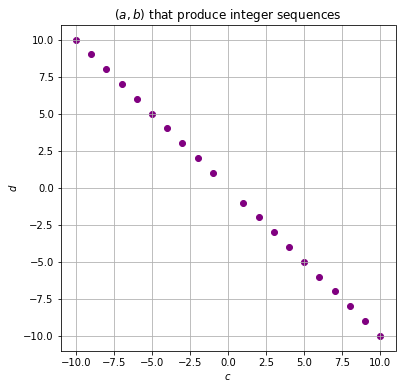

In [172]:
c_range = list(range(-20,20))
c_range.remove(0)
d_range = c_range

coords = []

for c in c_range:
    for d in d_range:
        if d%c == 0 and abs(c)<abs(d):
            continue
        array = deg_1_sqnc(-20,20,21,c,d)
        test = int_sqnc_check(array)
        if len(test) > 1:
            coords.append((c,d))
            
c_coords = [coord[0] for coord in coords]
d_coords = [coord[1] for coord in coords]

plt.figure(figsize = (6,6))
plt.scatter(c_coords,d_coords, c = 'purple')
plt.title('$(a,b)$ that produce integer sequences')
plt.xlabel('$c$')
plt.ylabel('$d$')
plt.grid()
plt.show()

In [176]:
int_sqnc_check(deg_1_sqnc(-20,20,21,4,-4))

[(4, 4), (12, 12), (20, 20), (28, 28), (36, 36)]

In [179]:
deg_1_case(16,21,4,-4)

[0,
 Fraction(1, 1),
 Fraction(2, 1),
 Fraction(4, 1),
 Fraction(8, 1),
 Fraction(16, 1),
 Fraction(32, 1),
 Fraction(64, 1),
 Fraction(128, 1),
 Fraction(256, 1),
 Fraction(512, 1),
 Fraction(1024, 1),
 Fraction(2048, 1),
 Fraction(4096, 1),
 Fraction(8192, 1),
 Fraction(16384, 1),
 Fraction(32768, 1),
 Fraction(65536, 1),
 Fraction(131072, 1),
 Fraction(262144, 1),
 Fraction(524288, 1)]

## From Here

Gotta implement some scatter plots, and arrange by color for geometric sequences, geometric sequences times $\sigma(n)$, wild sequences. This can be done by overlaying plots.

It's worth noting the pairs $(a,b)$ that give us sequences of zeros. When we have $(a,b) = (a,-a)$, and we define our sequence by
$$
\tau(n) = \frac{1}{n^p(xn+y)}\sum_{u+v=n}(au^2+buv)\tau(u)\tau(v),
$$
with our first term $\tau(1) = 1$, we find that
$$
\tau(2) = (a(1^2) - a(1)(1))\tau(1)\tau(1) = a-a = 0.
$$
Then, since every following term calls on $\tau(k)$ with $k \geq 2$, every term must be 0. Therefore, any quadratic/cubic touchard recurrence with $(a,b) = (a,-a)$ must produce a sequence of the form $\{1,0,0,0,\dots\}$. This can be extended to higher-degree cases as well.

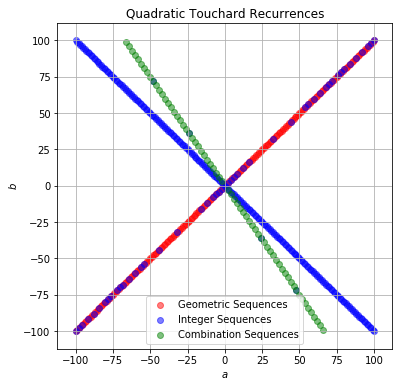

In [353]:
A = deg_2_sqnc(-100,100,-100,100,21)
combo = A/(deg_2_sqnc(-24,-24,36,36,21))
geom_coords = geom_sqnc_check(A,-100,-100)
int_coords = int_sqnc_check(A,-100,-100)
combo_coords = geom_sqnc_check(combo,-100,-100)

geoma_coords = [coords[0] for coords in geom_coords]
geomb_coords = [coords[1] for coords in geom_coords]

inta_coords = [coords[0] for coords in int_coords]
intb_coords = [coords[1] for coords in int_coords]

comboa_coords = [coords[0] for coords in combo_coords]
combob_coords = [coords[1] for coords in combo_coords]

plt.figure(figsize = (6,6))
plt.scatter(geoma_coords,geomb_coords, c = 'red', alpha=.5, label = 'Geometric Sequences')
plt.scatter(inta_coords,intb_coords, c = 'blue', alpha=.5, label = 'Integer Sequences')
plt.scatter(comboa_coords,combob_coords, c = 'green', alpha=.5, label = 'Combination Sequences')
plt.title('Quadratic Touchard Recurrences')
plt.grid()
plt.xlabel('$a$')
plt.ylabel('$b$')
plt.legend()
plt.show()

In [333]:
A[140,140]

array([ 0.00000000e+00,  1.00000000e+00, -4.00000000e+00,  1.60000000e+01,
       -6.40000000e+01,  2.56000000e+02, -1.02400000e+03,  4.09600000e+03,
       -1.63840000e+04,  6.55360000e+04, -2.62144000e+05,  1.04857600e+06,
       -4.19430400e+06,  1.67772160e+07, -6.71088640e+07,  2.68435456e+08,
       -1.07374182e+09,  4.29496730e+09, -1.71798692e+10,  6.87194767e+10,
       -2.74877907e+11])

In [56]:
nice_list = []
for n in range(len(int_coords)):
    coord = int_coords[n]
    if coord[0] == coord[1]:
        nice_list.append(coord)
        
nice_list

[(-100, -100, 0, 0),
 (-98, -98, 2, 2),
 (-96, -96, 4, 4),
 (-92, -92, 8, 8),
 (-88, -88, 12, 12),
 (-84, -84, 16, 16),
 (-80, -80, 20, 20),
 (-78, -78, 22, 22),
 (-76, -76, 24, 24),
 (-72, -72, 28, 28),
 (-70, -70, 30, 30),
 (-68, -68, 32, 32),
 (-64, -64, 36, 36),
 (-60, -60, 40, 40),
 (-56, -56, 44, 44),
 (-54, -54, 46, 46),
 (-44, -44, 56, 56),
 (-32, -32, 68, 68),
 (-16, -16, 84, 84),
 (-12, -12, 88, 88),
 (-8, -8, 92, 92),
 (-6, -6, 94, 94),
 (-4, -4, 96, 96),
 (-2, -2, 98, 98),
 (0, 0, 100, 100),
 (2, 2, 102, 102),
 (4, 4, 104, 104),
 (6, 6, 106, 106),
 (8, 8, 108, 108),
 (12, 12, 112, 112),
 (16, 16, 116, 116),
 (32, 32, 132, 132),
 (44, 44, 144, 144),
 (54, 54, 154, 154),
 (56, 56, 156, 156),
 (60, 60, 160, 160),
 (64, 64, 164, 164),
 (68, 68, 168, 168),
 (70, 70, 170, 170),
 (72, 72, 172, 172),
 (76, 76, 176, 176),
 (78, 78, 178, 178),
 (80, 80, 180, 180),
 (84, 84, 184, 184),
 (88, 88, 188, 188),
 (92, 92, 192, 192),
 (96, 96, 196, 196),
 (98, 98, 198, 198),
 (100, 100, 200,

I wanted to get a better look at what's going on with the nonzero integer sequences. The coordinates seemed to spread out and then cluster at points

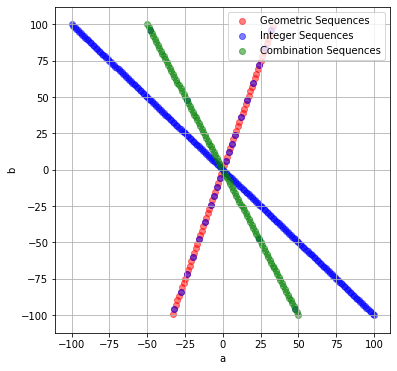

In [216]:
A = deg_3_sqnc(-100,100,-100,100,21)
combo = A/(deg_2_sqnc(-24,-24,36,36,21))
geom_coords = geom_sqnc_check(A,-100,-100)
int_coords = int_sqnc_check(A,-100,-100)
combo_coords = geom_sqnc_check(combo,-100,-100)

geoma_coords = [coords[0] for coords in geom_coords]
geomb_coords = [coords[1] for coords in geom_coords]

inta_coords = [coords[0] for coords in int_coords]
intb_coords = [coords[1] for coords in int_coords]

comboa_coords = [coords[0] for coords in combo_coords]
combob_coords = [coords[1] for coords in combo_coords]

plt.figure(figsize = (6,6))
plt.scatter(geoma_coords,geomb_coords, c = 'red', alpha=.5, label = 'Geometric Sequences')
plt.scatter(inta_coords,intb_coords, c = 'blue', alpha=.5, label = 'Integer Sequences')
plt.scatter(comboa_coords,combob_coords, c = 'green', alpha=.5, label = 'Combination Sequences')
plt.grid()
plt.xlabel('a')
plt.ylabel('b')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


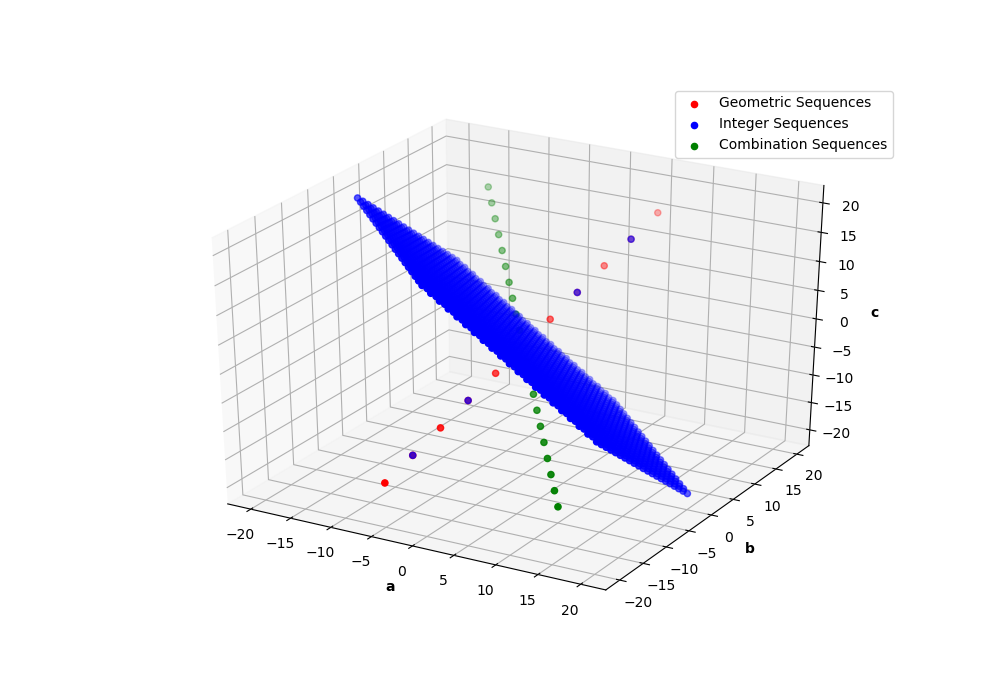

In [61]:
%matplotlib notebook

A = deg_4_sqnc(-20,20,-20,20,-20,20,21)
combo = A/(deg_2_sqnc(-24,-24,36,36,21))
geom_coords = geom_sqnc_check(A,-20,-20,-20)
int_coords = int_sqnc_check(A,-20,-20,-20)
combo_coords = geom_sqnc_check(combo,-20,-20,-20)

geoma_coords = [coords[0] for coords in geom_coords]
geomb_coords = [coords[1] for coords in geom_coords]
geomc_coords = [coords[2] for coords in geom_coords]

inta_coords = [coords[0] for coords in int_coords]
intb_coords = [coords[1] for coords in int_coords]
intc_coords = [coords[2] for coords in int_coords]

comboa_coords = [coords[0] for coords in combo_coords]
combob_coords = [coords[1] for coords in combo_coords]
comboc_coords = [coords[2] for coords in combo_coords]

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter(geoma_coords,geomb_coords,geomc_coords, c = 'red', label = 'Geometric Sequences') # geometric sequences
ax.scatter(inta_coords,intb_coords,intc_coords, c = 'blue', label = 'Integer Sequences') # integer sequences sequences
ax.scatter(comboa_coords,combob_coords,comboc_coords, c = 'green', label = 'Combination Sequences') # combo sequences
ax.set_xlabel('a', fontweight ='bold')
ax.set_ylabel('b', fontweight ='bold')
ax.set_zlabel('c', fontweight ='bold')
ax.legend()
plt.show()

<IPython.core.display.Javascript object>


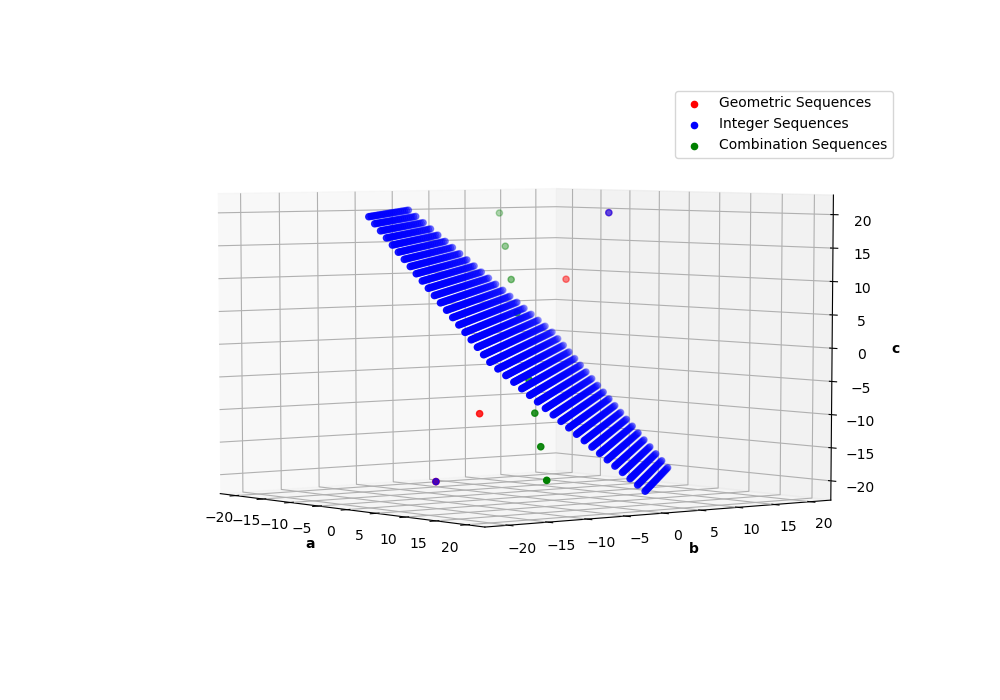

In [62]:
%matplotlib notebook

A = deg_5_sqnc(-20,20,-20,20,-20,20,21)
combo = A/(deg_2_sqnc(-24,-24,36,36,21))
geom_coords = geom_sqnc_check(A,-20,-20,-20)
int_coords = int_sqnc_check(A,-20,-20,-20)
combo_coords = geom_sqnc_check(combo,-20,-20,-20)

geoma_coords = [coords[0] for coords in geom_coords]
geomb_coords = [coords[1] for coords in geom_coords]
geomc_coords = [coords[2] for coords in geom_coords]

inta_coords = [coords[0] for coords in int_coords]
intb_coords = [coords[1] for coords in int_coords]
intc_coords = [coords[2] for coords in int_coords]

comboa_coords = [coords[0] for coords in combo_coords]
combob_coords = [coords[1] for coords in combo_coords]
comboc_coords = [coords[2] for coords in combo_coords]

fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter(geoma_coords,geomb_coords,geomc_coords, c = 'red', label = 'Geometric Sequences') # geometric sequences
ax.scatter(inta_coords,intb_coords,intc_coords, c = 'blue', label = 'Integer Sequences') # integer sequences sequences
ax.scatter(comboa_coords,combob_coords,comboc_coords, c = 'green', label = 'Combination Sequences') # combo sequences
ax.set_xlabel('a', fontweight ='bold')
ax.set_ylabel('b', fontweight ='bold')
ax.set_zlabel('c', fontweight ='bold')
ax.legend()
plt.show()

In [305]:
combo_coords

[(-4, 0, 20),
 (-3, 0, 15),
 (-2, 0, 10),
 (-1, 0, 5),
 (1, 0, -5),
 (2, 0, -10),
 (3, 0, -15),
 (4, 0, -20)]

## A Proof

We notice that every sequence produced by the linear case seems to produce a geometric sequence. We first prove this, and then use that fact to show that we get a geometric sequence from the quadratic case if $(a,b) = (a,a)$. By multiplying $\tau(n)$ iteratively by $\frac{n}{n}$, we can determine at least one branch of geometric sequences for any higher-order case, but I'll show this for the quadratic case.

Let $\tau(n) = \frac{1}{n(n-1)}\sum_{u+v=n}au\tau(u)\tau(v)$. With the prior defined function, we notice a pattern than $\tau(n) = \left(\frac{a}{2}\right)^{n-1}$.

In [27]:
deg_1_case(3,10)

[0,
 Fraction(1, 1),
 Fraction(3, 2),
 Fraction(9, 4),
 Fraction(27, 8),
 Fraction(81, 16),
 Fraction(243, 32),
 Fraction(729, 64),
 Fraction(2187, 128),
 Fraction(6561, 256)]

We use strong induction.

As per the definition of the sequence, $\tau(1) = 1$, and $1 = \frac{a^{1-1}}{2^{1-1}}$. Therefore the base case holds.

Suppose $\tau(k) = \left(\frac{a}{2}\right)^{n-1}$ for every $k \in \mathbb{N}$ with $1 \leq k \leq n$. We want to show that $\tau(n+1) = \left(\frac{a}{2}\right)^n$. In particular, we can show that $\tau(n+1) = \frac{a}{2}\tau(n)$, or $\frac{\tau(n+1)}{\tau(n)} = \frac{a}{2}$.
$$
\frac{\tau(n+1)}{\tau(n)} = \frac{\frac{1}{n(n+1)}\sum_{u+v=n+1}au\tau(u)\tau(v)}{\tau(n)} = \frac{\frac{1}{n(n+1)}\sum_{u+v=n+1}u\tau(u)\tau(v)}{\frac{a^{n-1}}{2^{n-1}}} = \frac{2^{n-1}}{a^{n-1}}\frac{1}{n(n+1)}\sum_{u+v=n+1}u\tau(u)\tau(v)
$$
We consider the individual terms of $\sum_{u+v=n+1}u\tau(u)\tau(v)$, noting that each $k \leq n$ term holds.
$$
\sum_{u+v=n+1}au\tau(u)\tau(v)
$$
$$
= a\tau(1)\tau(n) + 2a\tau(2)\tau(n-1) + 3a\tau(3)\tau(n-2) + \cdots + na\tau(n)\tau(1)
$$
$$
= \left(a\frac{a^{n-1}}{2^{n-1}}\right) + \left(2a\frac{a}{2}\frac{a^{n-2}}{2^{n-2}}\right) + \left(3a\frac{a^2}{4}\frac{a^{n-3}}{2^{n-3}}\right)\cdots + \left(na\frac{a^{n-1}}{2^{n-1}}\right)
$$
$$
= a\frac{a^{n-1}}{2^{n-1}} + 2a\frac{a^{n-1}}{2^{n-1}} + 3a\frac{a^{n-1}}{2^{n-1}} + \cdots + na\frac{a^{n-1}}{2^{n-1}}.
$$
Then
$$
\frac{2^{n-1}}{a^{n-1}}\frac{1}{n(n+1)}\sum_{u+v=n+1}u\tau(u)\tau(v)
$$
$$
= \frac{2^{n-1}}{a^{n-1}}\frac{1}{n(n+1)}\left(a\frac{a^{n-1}}{2^{n-1}}+ 2a\frac{a^{n-1}}{2^{n-1}} + 3a\frac{a^{n-1}}{2^{n-1}} + \cdots + na\frac{a^{n-1}}{2^{n-1}}\right)
$$
$$
= \frac{1}{n(n-1)}(a + 2a + 3a + \cdots + na)
$$
$$
= \frac{a}{n(n+1)}(1 + 2 + 3 + \cdots + n)
$$
$$
\frac{a}{n(n+1)}\sum_{k=1}^nk
$$
$$
\frac{a}{n(n+1)}\frac{n(n+1)}{2} = \frac{a}{2},
$$
Hence $\tau(n) = \frac{1}{n(n-1)}\sum_{u+v=n}au\tau(u)\tau(v) = \left(\frac{a}{2}\right)^{n-1}$ for all $n \in \mathbb{N}$.

Furthermore, since $u+v=n$, we have
$$
\left(\frac{a}{2}\right)^{n-1} = \tau(n) = \frac{n}{n}\tau(n) = \frac{n}{n}\frac{1}{n(n-1)}\sum_{u+v=n}au\tau(u)\tau(v)
$$
$$
= \frac{1}{n^2(n-1)}\sum_{u+v=n}aun\tau(u)\tau(v) = \frac{1}{n^2(n-1)}\sum_{u+v=n}au(u+v)\tau(u)\tau(v)
$$
$$
= \frac{1}{n^2(n-1)}\sum_{u+v=n}(au^2+auv)\tau(u)\tau(v),
$$
thus giving us a branch of geometric sequences for the quadratic case.

By iterating this process of multiplying the sequence by $\frac{n}{n}$, we maintain the geometric sequence while increasing the degree of the polynomial in the sum, thus giving us at least one branch of geometric sequences for every degree $\geq 2$.

## Wild Sequences

"$\tau(n)$ is <u>wild</u> if the set of prime numbers dividing the denominators in the sequence $\tau(n)$ is infinite. In particular, there does not exist a positive integer $N \in \mathbb{Z}$ such that, for all $n \geq 1$, $\tau(n)\cdot N^n \in \mathbb{Z}$."

The hope is that everything $(a,b) \neq (a,a), (a,-a)$, or $(-2k,3k)$, $k \in \mathbb{Z}$ is wild.

In [45]:
deg_2_case(3,4,21)

[0,
 Fraction(1, 1),
 Fraction(7, 4),
 Fraction(217, 72),
 Fraction(497, 96),
 Fraction(14217, 1600),
 Fraction(39516379, 2592000),
 Fraction(949042331, 36288000),
 Fraction(45580915039, 1016064000),
 Fraction(1809317314099, 23514624000),
 Fraction(186193659949907, 1410877440000),
 Fraction(1932006237687842669, 8535808512000000),
 Fraction(437384394639364019191, 1126726723584000000),
 Fraction(253545234922198028816101, 380833632571392000000),
 Fraction(17586759602130147324784753, 15402604695109632000000),
 Fraction(239422750661203603026724509839, 122265876069780258816000000),
 Fraction(87988275987762430397773768153901, 26199830586381484032000000000),
 Fraction(5130599047611126273607269076697351, 890794239936970457088000000000),
 Fraction(16154876837790621484718343671816911403, 1635498224524277759213568000000000),
 Fraction(16366371264826715298650679616512416065511, 966133405723523352669978624000000000),
 Fraction(4692987952943518410128700348590452427246537, 1615375054369731045664204259

In [46]:
deg_2_case(-1,8,21)

[0,
 Fraction(1, 1),
 Fraction(7, 4),
 Fraction(21, 8),
 Fraction(371, 96),
 Fraction(1351, 240),
 Fraction(52213, 6400),
 Fraction(4753319, 403200),
 Fraction(383932699, 22579200),
 Fraction(105346579, 4300800),
 Fraction(8187519359, 232243200),
 Fraction(142492342513189, 2810142720000),
 Fraction(166912437586403, 2289745920000),
 Fraction(3946461249081089, 37673475840000),
 Fraction(264153916886584977751, 1755282586337280000),
 Fraction(55082029646906373437, 254841027349708800),
 Fraction(2288124106782966886587883, 7372186862616576000000),
 Fraction(15190324549728270226415689823, 34088992052739047424000000),
 Fraction(762760230939250265716327511, 1192413302256304128000000),
 Fraction(13829940941919794596186417738521467, 15062698384391486450958336000000),
 Fraction(7542506695305342186878800566342511, 5723825386068764851364167680000)]

In [48]:
deg_2_case(30,-31,21)

[0,
 Fraction(1, 1),
 Fraction(-1, 4),
 Fraction(-13, 36),
 Fraction(-497, 576),
 Fraction(-64639, 28800),
 Fraction(-2976803, 518400),
 Fraction(-14443487, 1036800),
 Fraction(-7327384439, 232243200),
 Fraction(-4980922817587, 75246796800),
 Fraction(-1444757089041653, 11287019520000),
 Fraction(-88544902061078659, 390208389120000),
 Fraction(-26375500230575352443, 72110510309376000),
 Fraction(-4567963435911259734451, 8653261237125120000),
 Fraction(-10606393734986889597941, 16070342297518080000),
 Fraction(-154579708155965404924509893, 236234031773515776000000),
 Fraction(-118329742082496246336235637, 348899493080884838400000),
 Fraction(13340562448009758372175592720873, 26216307910097686757376000000),
 Fraction(14517406341143278382615144702595541, 6876163046134193269506048000000),
 Fraction(357537862358072281639258364999310228931, 78192288079114978764188024832000000),
 Fraction(4563580791599110265344839682010918323314371, 594261389401273838607828988723200000000)]

In [93]:
deg_2_case(5,4,21)

[0,
 Fraction(1, 1),
 Fraction(9, 4),
 Fraction(41, 8),
 Fraction(1123, 96),
 Fraction(42747, 1600),
 Fraction(1171831, 19200),
 Fraction(262370741, 1881600),
 Fraction(5595004043, 17561600),
 Fraction(2070985730477, 2844979200),
 Fraction(4258821266875663, 2560481280000),
 Fraction(261659929524837157, 68848496640000),
 Fraction(15784088616418729547, 1817600311296000),
 Fraction(548566688796804911678947, 27645700734812160000),
 Fraction(50695647098788706094699833, 1118115007496847360000),
 Fraction(851415548017194916818755485967, 8218145305101828096000000),
 Fraction(4669144084421869314951207012821, 19723548732244387430400000),
 Fraction(10277772360722752244306968903956301, 19000351945395426557952000000),
 Fraction(14372623984070468232994274000216653583, 11628215390582001053466624000000),
 Fraction(1920632750763492265281854018192802020320309, 680041292472016585608835104768000000),
 Fraction(926492248053961583088297066341933694195416029, 143564272855203501406309633228800000000)]